## School project - 5DEEP
The following notebook has been created for a school project on audio classification. The subject and the questions are available in the appendix.

The group members who participated in this project are:
- AMIMI Lamine
- BEZIN Théo
- LECOMTE Alexis
- PAWLOWSKI Maxence

### Main index
1. Data analysis
2. Data preprocessing
3. Basic ANN model
4. **The CNN model (you are here)**
5. The model competition
6. Data augmentation
7. _Appendix_

# 4 - The CNN model
Our previous model showed very poor performance on the Mel spectrogram. For this notebook, we will define a Convolutional Neural Network (CNN) that takes a three-dimensional array as input. The extra dimensions will allow the model to train better by extracting more features from the spectrograms.

### Index
<ol type="A">
  <li>Notebook initialization</li>
  <li>Data preparation</li>
  <li>Second model: Convolutional Neural Network (CNN)</li>
  <li>Evaluating the model</li>
  <li>Conclusion of the CNN model</li>
</ol>

## A - Notebook initialization
### A.1 - Imports

In [2]:
# OS and filesystem
import os
import sys
from pathlib import Path
from timeit import default_timer as timer
from datetime import timedelta

# Math
import numpy
import pandas

# Data
from matplotlib import pyplot

# Model processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras

# Console output
from colorama import Style

# Local files
sys.path.append(os.path.join(os.pardir, os.pardir))
import helpers

### A.2 - Package initialization

In [3]:
pyplot.style.use("ggplot")  # Set the matplotlib style
keras.backend.set_image_data_format("channels_last")  # Define the last value of the model input shape as the color channel

### A.3 - Constants

In [4]:
# Filesystem paths
PARENT_FOLDER = Path.cwd()
DATA_FOLDER = (PARENT_FOLDER / ".." / ".." / "data").resolve()
URBAN_DATASET_FOLDER = DATA_FOLDER / "UrbanSound8K"
MODELS_FOLDER = (PARENT_FOLDER / ".." / ".." / "models").resolve()
TEMP_FOLDER = (PARENT_FOLDER / ".." / ".." / "temp").resolve()

# Dataset
CLASSES = ["air_conditioner", "car_horn", "children_playing", "dog_bark", "drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]
N_MELS = 128

# Misc.
RANDOM_STATE = 2077

### A.4 - Dataset loading

In [5]:
features_x = numpy.load(file=(str(DATA_FOLDER / "x-mel-spectrograms_13-02-23_14-44.npy")))
features_y = numpy.load(file=(str(DATA_FOLDER / "y-mel-spectrograms_13-02-23_14-44.npy")))

## B - Data preparation
### B.1 - Label encoding
We will use the same encoding method as for the ANN model, a one-hot encoding.

In [6]:
label_encoder = LabelEncoder()
features_y = keras.utils.to_categorical(y=label_encoder.fit_transform(features_y), num_classes=len(CLASSES))

### B.2 - Dataset splitting

In [7]:
x_train, x_test, y_train, y_test = train_test_split(features_x, features_y, test_size=0.2, random_state=RANDOM_STATE)

print(f"{Style.BRIGHT}Train set >{Style.RESET_ALL} rows: (x={len(x_train)}, y={len(y_train)}) | shape: (x={x_train.shape}, y={y_train.shape})")
print(f"{Style.BRIGHT}Test set >{Style.RESET_ALL} rows: (x={len(x_test)}, y={len(y_test)}) | shape: (x={x_test.shape}, y={y_test.shape})")

Train set > rows: (x=6985, y=6985) | shape: (x=(6985, 128, 173), y=(6985, 10))
Test set > rows: (x=1747, y=1747) | shape: (x=(1747, 128, 173), y=(1747, 10))


The input layer of the CNN model takes a 4+D tensor with the form $batchShape, (rows, cols, channels)$. We need to reshape our dataset to match the second part in parentheses.

In [8]:
num_columns = 173
num_channels = 1

x_train = x_train.reshape(x_train.shape[0], N_MELS, num_columns, num_channels)
x_test = x_test.reshape(x_test.shape[0], N_MELS, num_columns, num_channels)

## C - Second model: Convolutional Neural Network (CNN)
### C.1 - Model architecture
We will use the same model API as for the ANN, the [Sequential](https://keras.io/guides/sequential_model/) API.

1. The first three groups start with a [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layer. It creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. The input shape of this layer is $batchShape, (rows, cols, channels)$ and the output shape is $batchShape, (newRows, newCols, filters)$. The next layer is a [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/) layer that down-samples the input along its spatial dimensions (height and width). The final layer of those groups is the [activation function](https://keras.io/api/layers/core_layers/activation/).
2. The fourth group begins with a [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/) layer used, as the name suggests, to flatten the input. This group ends with the [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) layer which "removes" input values by setting them to 0. This layer prevents over-fitting.
3. The last two groups are classic [Dense](https://keras.io/api/layers/core_layers/dense/) layers with a [softmax](https://keras.io/api/layers/activations/#softmax-function) activation function for the final output.

### C.2 - Model definition

Model: "CNN_Milva"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 125, 170, 32)      544       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 85, 32)       0         
 2D)                                                             
                                                                 
 activation_3 (Activation)   (None, 62, 85, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 59, 82, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 20, 64)       0         
 2D)                                                             
                                                                 
 activation_4 (Activation)   (None, 14, 20, 64)        0 

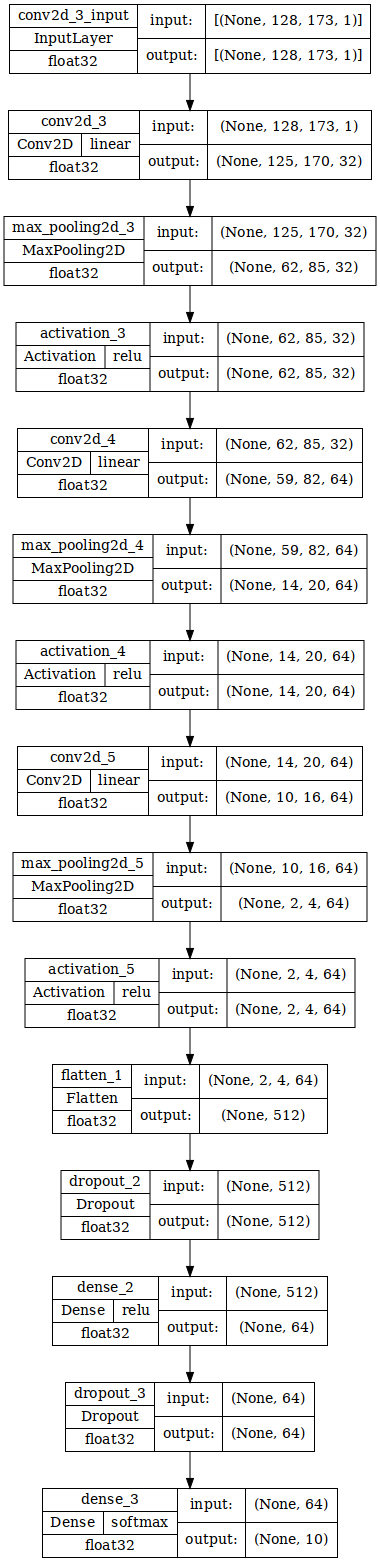

In [10]:
# Model definition
model_cnn_milva = keras.models.Sequential(name="CNN_Milva", layers=[
    # First convolution block
    keras.layers.Conv2D(filters=32, kernel_size=(4, 4), strides=(1, 1), input_shape=(N_MELS, num_columns, num_channels)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    keras.layers.Activation("relu"),

    # Second convolution block
    keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(1, 1), padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4)),
    keras.layers.Activation("relu"),

    # Third convolution block
    keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding="valid"),
    keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4)),
    keras.layers.Activation("relu"),

    # Flatten and dropout
    keras.layers.Flatten(),
    keras.layers.Dropout(rate=0.5),

    # First dense block
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(rate=0.5),

    # Second dense block. Using softmax to reduce to output to 10
    keras.layers.Dense(len(CLASSES), activation="softmax")
])

# Model summary and plot
model_cnn_milva.summary()
keras.utils.plot_model(
    model_cnn_milva,
    show_shapes=True, show_dtype=True, show_layer_names=True, show_layer_activations=True,
    rankdir="TB", dpi=72,
    to_file=(TEMP_FOLDER / "model_cnn_milva.png")
)

### C.3 - Model optimizer and loss function

In [11]:
adam_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model_cnn_milva.compile(loss="categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])

### C.4 - Model callbacks

In [12]:
# Model checkpoint to save the model to the disk
ckpt_name_base = "2_model-cnn-milva-ckpt"

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=str(MODELS_FOLDER / f"{ckpt_name_base}_e-{{epoch:02d}}_vloss-{{val_loss:.2f}}.hdf5"),
    monitor="val_loss",
    save_best_only=True,
    verbose=0
)

### C.5 - Model training

In [13]:
batch_size = 128
epochs = 200

start_time = timer()
training_cnn_milva = model_cnn_milva.fit(x=x_train, y=y_train, validation_split=0.080, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint_callback], verbose=1)
print(f"The training of the \"{model_cnn_milva.name}\" model took {timedelta(seconds=(timer() - start_time))}.")

2023-02-14 22:18:22.971694: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 569189376 exceeds 10% of free system memory.
2023-02-14 22:18:23.336165: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 569189376 exceeds 10% of free system memory.


Epoch 1/200


2023-02-14 22:18:35.337670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-14 22:18:41.645639: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-14 22:18:42.568688: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fde1800ec60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-14 22:18:42.568740: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2023-02-14 22:18:42.587193: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-14 22:18:42.847371: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-14 22:18:42.897085: I tensorflow/compiler/jit/xla_compilati

51/51 [==============================] - 41s 72ms/step - loss: 2.1461 - accuracy: 0.2004 - val_loss: 1.8150 - val_accuracy: 0.3614
Epoch 2/200
51/51 [==============================] - 3s 64ms/step - loss: 1.7297 - accuracy: 0.3739 - val_loss: 1.3307 - val_accuracy: 0.5295
Epoch 3/200
51/51 [==============================] - 3s 63ms/step - loss: 1.4804 - accuracy: 0.4829 - val_loss: 1.1676 - val_accuracy: 0.5939
Epoch 4/200
51/51 [==============================] - 3s 64ms/step - loss: 1.2760 - accuracy: 0.5532 - val_loss: 1.0224 - val_accuracy: 0.6601
Epoch 5/200
51/51 [==============================] - 3s 64ms/step - loss: 1.1544 - accuracy: 0.5976 - val_loss: 0.9621 - val_accuracy: 0.6834
Epoch 6/200
51/51 [==============================] - 3s 63ms/step - loss: 1.0382 - accuracy: 0.6441 - val_loss: 0.8835 - val_accuracy: 0.6762
Epoch 7/200
51/51 [==============================] - 3s 64ms/step - loss: 0.9568 - accuracy: 0.6776 - val_loss: 0.8401 - val_accuracy: 0.7388
Epoch 8/200
51/51

We save the training history to the disk for later use.

In [ ]:
history = pandas.DataFrame(training_cnn_milva.history)
history.to_csv(MODELS_FOLDER / "histories" / "2_model-cnn-milva_16-02-23_10-45.csv")

### C.6 - Loading the best model

In [17]:
best_model = helpers.ckpts.load_best_model(models_folder=MODELS_FOLDER, base_name=ckpt_name_base)

## D - Evaluating the model
### D.1 - Accuracy and loss

In [18]:
helpers.perfs.print_model_metrics(model=best_model, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)

Model metrics:
Training > loss=0.061 | accuracy=98.497
Testing > loss=0.375 | accuracy=90.269


As with the ANN, the loss value between the training and test sets is almost the same. Our model neither over-fits nor under-fits the dataset. But its accuracy is much better than our previous model. Getting an accuracy of almost 90% on the test set is a very good result.

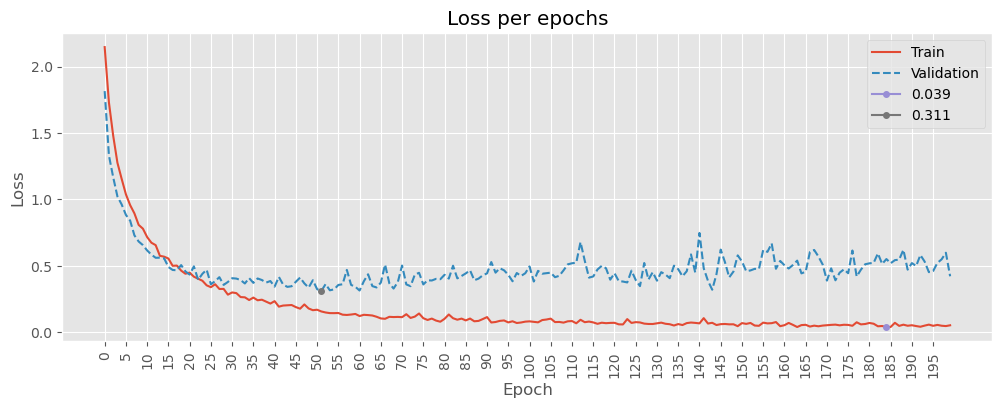

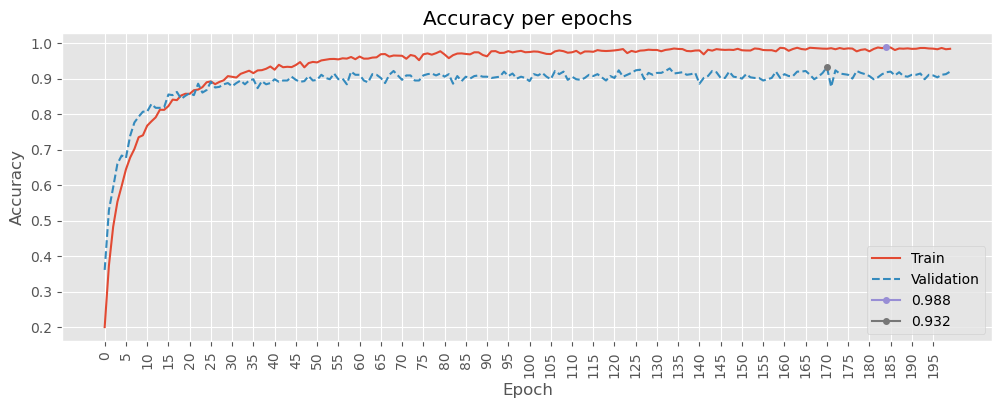

In [19]:
helpers.perfs.plot_loss_curve(history=training_cnn_milva.history)
helpers.perfs.plot_accuracy_curve(history=training_cnn_milva.history)

These two graphs look better than with the ANN. We can see that the validation loss increases around the 60th epoch, our best model was taken at the 52nd epoch. It does not have the best accuracy (98.8 on the training set, 93.2 on the test set), but its loss value is very close to the lowest recorded.

### D.2 - Confusion matrix

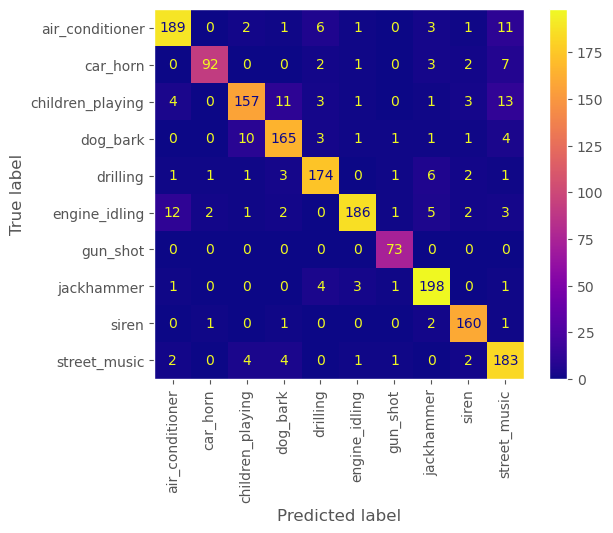

              Class Accuracy
0   air_conditioner  88.32 %
1          car_horn  85.98 %
2  children_playing  81.35 %
3          dog_bark  88.71 %
4          drilling  91.58 %
5     engine_idling  86.92 %
6          gun_shot  100.0 %
7        jackhammer  95.19 %
8             siren  96.97 %
9      street_music  92.89 %


In [20]:
helpers.perfs.plot_confusion_matrix(model=best_model, x_test=x_test, y_test=y_test, le=label_encoder, classes=CLASSES)

We can easily see the diagonal from top-left corner to the bottom-right corner, which means that our model is not very confused. We notice a lower score for the `car_horn` and `gun_shot` classes, but these classes have almost 50% of data compared to the other classes.

There is some confusion between classes of sounds that may seem similar: `engine_idling` and `air_conditioner`. But there is also confusion between classes that seem quite different. The class `children_playing` is most often confused with `dog_bark` and `street_music`.

### D.3 - Classification report

In [21]:
helpers.perfs.print_classification_report(model=best_model, x_test=x_test, y_test=y_test, le=label_encoder, classes=CLASSES)

                  precision    recall  f1-score   support

 air_conditioner       0.90      0.88      0.89       214
        car_horn       0.96      0.86      0.91       107
children_playing       0.90      0.81      0.85       193
        dog_bark       0.88      0.89      0.88       186
        drilling       0.91      0.92      0.91       190
   engine_idling       0.96      0.87      0.91       214
        gun_shot       0.94      1.00      0.97        73
      jackhammer       0.90      0.95      0.93       208
           siren       0.92      0.97      0.95       165
    street_music       0.82      0.93      0.87       197

        accuracy                           0.90      1747
       macro avg       0.91      0.91      0.91      1747
    weighted avg       0.90      0.90      0.90      1747



## E - Conclusion of the CNN model
**TODO**